## Content:
##### - Try one solution of papers with code and try it
##### - Chosen solution SpinalNet

In the proposed SpinalNet, each layer is split into three splits: 1) input split, 2) intermediate split, and 3) output split. Input split of each layer receives a part of the inputs. The intermediate split of each layer receives outputs of the intermediate split of the previous layer and outputs of the input split of the current layer. The number of incoming weights becomes significantly lower than traditional DNNs. The SpinalNet can also be used as the fully connected or classification layer of DNN and supports both traditional learning and transfer learning.

- source: https://paperswithcode.com/sota/image-classification-on-cifar-100
- source: https://arxiv.org/pdf/2007.03347.pdf
- source: https://github.com/dipuk0506/SpinalNet

In [1]:
from __future__ import print_function, division
from torchvision.datasets import CIFAR100
import matplotlib
import imageio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchsummary import summary
import pickle

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Take a look at the the data augmenatation techniques (without normalization for visu):
##### 1. Training data:

Files already downloaded and verified
Training and valid data:


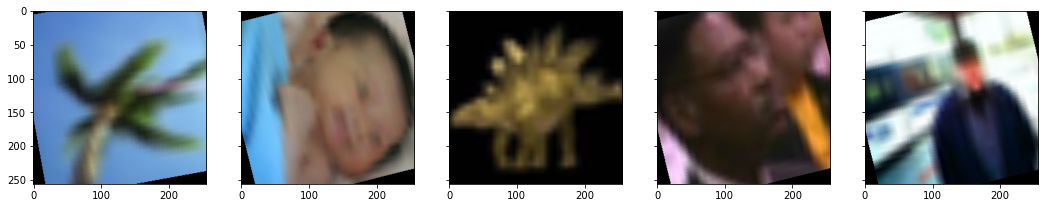

In [2]:
from torch.utils.data import random_split
batch_size = 64
RANDOM_SEED = 123

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((272,272)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
    ]),
     'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
    ]),
}


train_dataset = CIFAR100(root="./", train=True, download=False, transform=data_transforms['train'])
test_dataset = CIFAR100(root="./", train=False, download=True, transform=data_transforms['test'])

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, num_workers=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
torch.manual_seed(RANDOM_SEED)

for images, labels in train_loader:  
    images1 = images
    break
    
for images, labels in test_loader:  
    images2 = images
    break
    
print('Training and valid data:')
fig, axs = plt.subplots(1, 5, figsize=(18, 6), sharey=True)
for i in range(5):
    axs[i].imshow(np.transpose(images1[i], (1, 2, 0)))



Test data:


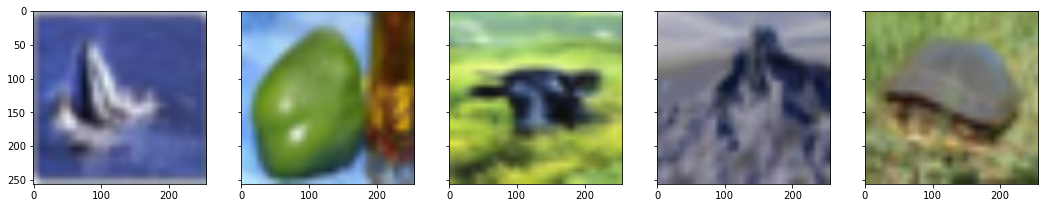

In [3]:
print('Test data:')
fig, axs = plt.subplots(1, 5, figsize=(18, 6), sharey=True)
for i in range(5):
    axs[i].imshow(np.transpose(images2[i], (1, 2, 0)))

### Create the dataset to train the network (with normalization):

In [4]:
from torch.utils.data import random_split
batch_size = 64


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((272,272)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
     'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

train_dataset = CIFAR100(root="./", train=True, download=True, transform=data_transforms['train'])
test_dataset = CIFAR100(root="./", train=False, download=True, transform=data_transforms['test'])

# Aufteilen des Trainingsdatensatzes in Trainings- und Validierungsdatensatz
val_size = int(0.2 * len(train_dataset))  
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# Anwenden der Transformationen auf den Trainings-, Validierungs- und Testdatensatz
#train_dataset.transform = data_transforms['train']
#val_dataset.transform = data_transforms['valid']
#test_dataset.transform = data_transforms['test']


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training images train data set: ', len(train_dataset))
print('Number of validation images in train dataset: ', len(val_dataset))
print('Number of test images test data set: ', len(test_dataset))

Files already downloaded and verified
Files already downloaded and verified
Number of training images train data set:  40000
Number of validation images in train dataset:  10000
Number of test images test data set:  10000


### Same training loop like before:

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    train_loss_list = []
    val_loss_list = []
    epoch_list = []

    total_step = len(train_loader)

    for epoch in range(num_epochs):
        epoch_train_loss = 0.0
        
        model.train()             # activate dropout
        for i, (images, labels) in enumerate(train_loader):
            # Move tensors to the configured device
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Add up the training loss for this batch
            epoch_train_loss += loss.item()

        # Compute the average training loss for this epoch
        epoch_train_loss /= len(train_loader)

        # Append the loss to the train_loss_list
        train_loss_list.append(epoch_train_loss)
        epoch_list.append(epoch+1)
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, epoch_train_loss))

        # Validation
        #model.eval()           # deactivate dropout
        with torch.no_grad():
            correct = 0
            total = 0
            val_loss = 0
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                del images, labels, outputs

            # Append the average validation loss to the val_loss_list
            val_loss /= len(valid_loader.dataset)
            val_loss_list.append(val_loss)
            print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))
         
        # in each epoch call scheduler 
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print("Current learning rate: {}".format(current_lr))

    # Plot the train and validation loss
    import matplotlib.pyplot as plt
    plt.plot(epoch_list, train_loss_list, label='Train Loss')
    plt.plot(epoch_list, val_loss_list, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

In [6]:
# Load the label names from metadata file
with open('cifar-100-python/meta', 'rb') as f:
    meta_dict = pickle.load(f, encoding='bytes')
fine_label_names = [t.decode('utf8') for t in meta_dict[b'fine_label_names']]
print(fine_label_names)

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

### Model:

Load ResNet101 from PyTorch with pretrained parameters
source: https://pytorch.org/vision/main/models/generated/torchvision.models.wide_resnet101_2.html

In [7]:
model_ft = models.wide_resnet101_2(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft = model_ft.to(device)

##### Show architecture of the wide_resNet101

In [8]:
summary(model_ft, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]           8,192
       BatchNorm2d-6            [-1, 128, 8, 8]             256
              ReLU-7            [-1, 128, 8, 8]               0
            Conv2d-8            [-1, 128, 8, 8]         147,456
       BatchNorm2d-9            [-1, 128, 8, 8]             256
             ReLU-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          32,768
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

#### Adapt SpinalNet to ResNet

In [9]:
half_in_size = round(num_ftrs/2)
layer_width = 200 #Small for Resnet, large for VGG
Num_class=100

class SpinalNet_ResNet(nn.Module):
    def __init__(self):
        super(SpinalNet_ResNet, self).__init__()
        
        self.fc_spinal_layer1 = nn.Sequential(
            nn.Linear(half_in_size, layer_width),
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer2 = nn.Sequential(
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer3 = nn.Sequential(
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.ReLU(inplace=True),)
        self.fc_spinal_layer4 = nn.Sequential(
            nn.Linear(half_in_size+layer_width, layer_width),
            nn.ReLU(inplace=True),)
        self.fc_out = nn.Sequential(
            nn.Linear(layer_width*4, Num_class),)
        
    def forward(self, x):
        x1 = self.fc_spinal_layer1(x[:, 0:half_in_size])
        x2 = self.fc_spinal_layer2(torch.cat([ x[:,half_in_size:2*half_in_size], x1], dim=1))
        x3 = self.fc_spinal_layer3(torch.cat([ x[:,0:half_in_size], x2], dim=1))
        x4 = self.fc_spinal_layer4(torch.cat([ x[:,half_in_size:2*half_in_size], x3], dim=1))
        
        
        x = torch.cat([x1, x2], dim=1)
        x = torch.cat([x, x3], dim=1)
        x = torch.cat([x, x4], dim=1)

        
        x = self.fc_out(x)
        return x
    



'''
Changing the fully connected layer to SpinalNet or VGG or ResNet
'''

#model_ft.fc = nn.Linear(num_ftrs, 100)
model_ft.fc = SpinalNet_ResNet() #SpinalNet_VGG

In [10]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

In [11]:
summary(model_ft, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5            [-1, 128, 8, 8]           8,192
       BatchNorm2d-6            [-1, 128, 8, 8]             256
              ReLU-7            [-1, 128, 8, 8]               0
            Conv2d-8            [-1, 128, 8, 8]         147,456
       BatchNorm2d-9            [-1, 128, 8, 8]             256
             ReLU-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          32,768
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

Epoch [1/25], Step [625/625], Loss: 1.9329
Accuracy of the network on the 5000 validation images: 67.98 %
Current learning rate: 0.01
Epoch [2/25], Step [625/625], Loss: 0.9370
Accuracy of the network on the 5000 validation images: 72.66 %
Current learning rate: 0.01
Epoch [3/25], Step [625/625], Loss: 0.6991
Accuracy of the network on the 5000 validation images: 73.22 %
Current learning rate: 0.01
Epoch [4/25], Step [625/625], Loss: 0.5566
Accuracy of the network on the 5000 validation images: 76.74 %
Current learning rate: 0.01
Epoch [5/25], Step [625/625], Loss: 0.4346
Accuracy of the network on the 5000 validation images: 77.43 %
Current learning rate: 0.01
Epoch [6/25], Step [625/625], Loss: 0.3602
Accuracy of the network on the 5000 validation images: 78.34 %
Current learning rate: 0.01
Epoch [7/25], Step [625/625], Loss: 0.3080
Accuracy of the network on the 5000 validation images: 77.98 %
Current learning rate: 0.01
Epoch [8/25], Step [625/625], Loss: 0.2640
Accuracy of the net

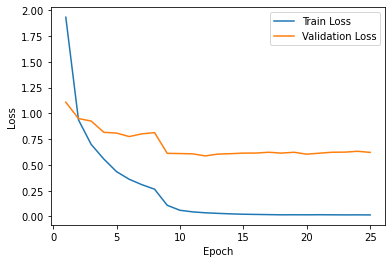

In [12]:
from sklearn.metrics import classification_report

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=8, gamma=0.1)

train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)




In [13]:
y_pred = []
y_true = []

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        # auf cpu kopieren um in numpy array umwandeln zu könenn
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))  

target_names = fine_label_names
classification_report_result = classification_report(y_true, y_pred, target_names=target_names)
print(classification_report_result)

Accuracy of the network on the 10000 test images: 84.66 %
               precision    recall  f1-score   support

        apple       0.97      0.94      0.95       100
aquarium_fish       0.98      0.95      0.96       100
         baby       0.78      0.73      0.76       100
         bear       0.80      0.78      0.79       100
       beaver       0.70      0.80      0.75       100
          bed       0.83      0.86      0.85       100
          bee       0.93      0.92      0.92       100
       beetle       0.89      0.89      0.89       100
      bicycle       0.98      0.92      0.95       100
       bottle       0.92      0.91      0.91       100
         bowl       0.67      0.74      0.70       100
          boy       0.62      0.68      0.65       100
       bridge       0.93      0.89      0.91       100
          bus       0.84      0.82      0.83       100
    butterfly       0.88      0.91      0.90       100
        camel       0.90      0.91      0.91       100
      

### Overview classes:

In [16]:
import pandas as pd
classification_report_result_dict = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
df_classification_report = pd.DataFrame(classification_report_result_dict).transpose()
df_classification_report[0:len(target_names)]

# Find best classified labels
sorted_df_precision = df_classification_report.sort_values('precision', ascending=False)
top5_sorted_precision = sorted_df_precision[0:5]
header_precision = "Top 5 labels precision"
sorted_df_precision = top5_sorted_precision.style.set_caption(header_precision)
sorted_df_precision

,precision,recall,f1-score,support
aquarium_fish,0.979381,0.950000,0.964467,100.000000
bicycle,0.978723,0.920000,0.948454,100.000000
sunflower,0.969072,0.940000,0.954315,100.000000
apple,0.969072,0.940000,0.954315,100.000000
lion,0.957447,0.900000,0.927835,100.000000


In [17]:
sorted_df_precision = df_classification_report.sort_values('precision')
worst5_sorted_precision = sorted_df_precision[0:5]
header_precision = "SpinalNet: Worst 5 labels precision"
sorted_df_precision = worst5_sorted_precision.style.set_caption(header_precision)
sorted_df_precision

,precision,recall,f1-score,support
boy,0.623853,0.680000,0.650718,100.000000
seal,0.645455,0.710000,0.676190,100.000000
oak_tree,0.647619,0.680000,0.663415,100.000000
willow_tree,0.653465,0.660000,0.656716,100.000000
otter,0.653846,0.680000,0.666667,100.000000


In [18]:
sorted_df_f1_score = df_classification_report.sort_values('f1-score')
worst5_sorted_f1_score = sorted_df_f1_score[0:5]
header_f1_score = "Worst 5 labels f1-score"
sorted_df_f1_score = worst5_sorted_f1_score.style.set_caption(header_f1_score)
sorted_df_f1_score

,precision,recall,f1-score,support
boy,0.623853,0.680000,0.650718,100.000000
willow_tree,0.653465,0.660000,0.656716,100.000000
oak_tree,0.647619,0.680000,0.663415,100.000000
otter,0.653846,0.680000,0.666667,100.000000
seal,0.645455,0.710000,0.676190,100.000000


## Summary:

#### -very big network compared to the other one: 125,857,796 parameters
#### - trained only 5 episodes (need much time because of the number of paramters, also GPU memory complete full)
#### - Good Accurancy 84.66%, big imrove on the test data